# Project 2

## Locally Weighted Regression

Locally weighted regression (LWR) is a regression based form of modelling. Its main feature is that it is able to fit a complex relationship between a target and its feature(s) while maintaining a smooth curve.

Mathematically, we can understand LWR by first looking at the principle equation of linear regression:

$$\large y = X\cdot\beta + \sigma\epsilon$$

We can weight this equation by some *W* by multiplying it to both sides:

$$Wy = WX\cdot\beta + \sigma W\epsilon$$

The usual weight used in LOESS is the tri cubic weight kernel. The weight on a given *x* using this kernel is: 

$$w(x) = (1-|d|^3)^3$$

Now let's try to convey this in code:

In [160]:
def lowess_kern(x, y, kern, tau):

    # tau is called bandwidth K((x-x[i])/(2*tau))

    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the kernel function by using only the train data    
    w = np.array([kern((x - x[i])/(2*tau)) for i in range(n)])     
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        theta, res, rnk, s = linalg.lstsq(A, b)
        yest[i] = theta[0] + theta[1] * x[i] 

    return yest

This function takes some input features in matrix $X$ and targets in $y$, a kernel which will dictate our weights, and a parameter tau which controls the number of points the function will consider "local" (in other words, the smoothness of the curve). Next, we will write the function enumerating our tricubic kernel.

In [161]:
def tricubic(x):
    if len(x.shape) == 1:
        x = x.reshape(-1,1)
    d = np.sqrt(np.sum(x**2, axis = 1))
    return np.where(d>1,0,70/81*(1-d**3)**3)

Now we're ready to go with real data! First, let's cover the method we will be comparing LWR against.

## Random Forest

Unlike LWR, random forest models use decision trees to estimate. Specifically, in the training phase of the model, a series of decision trees are made on a number of bootstrapped subsets of the data, with some given maximum depth. Then, the results of each of these decision trees is averaged to give a final estimate. We will use a random forest model from the scikit learn library for our model:

In [162]:
from sklearn.ensemble import RandomForestRegressor as RFR
model = RFR(n_estimators = 120, max_depth = 3)

## Data

Our data comes from two common datasets, mtcars and Boston housing prices.

In [163]:
import numpy as np
import pandas as pd
cars = pd.read_csv("mtcars.csv")
BHP = pd.read_csv('Boston Housing Prices.csv')

In [164]:
cars.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [165]:
BHP.head()

,town,tract,longitude,latitude,crime,residential,industrial,river,nox,rooms,older,distance,highway,tax,ptratio,lstat,cmedv
0,Nahant,2011,-70.955002,42.255001,0.00632,18.0,2.31,no,0.538,6.575,65.199997,4.0900,1,296,15.300000,4.98,24.000000
1,Swampscott,2021,-70.949997,42.287498,0.02731,0.0,7.07,no,0.469,6.421,78.900002,4.9671,2,242,17.799999,9.14,21.600000
2,Swampscott,2022,-70.935997,42.283001,0.02729,0.0,7.07,no,0.469,7.185,61.099998,4.9671,2,242,17.799999,4.03,34.700001
3,Marblehead,2031,-70.928001,42.292999,0.03237,0.0,2.18,no,0.458,6.998,45.799999,6.0622,3,222,18.700001,2.94,33.400002
4,Marblehead,2032,-70.921997,42.298000,0.06905,0.0,2.18,no,0.458,7.147,54.200001,6.0622,3,222,18.700001,5.33,36.200001


Our features will be weight and number of rooms, and the targets will be mpg and median price, respectively.

In [166]:
xcars = cars[['wt']]
ycars = cars[['mpg']]

xBHP = BHP[['rooms']]
yBHP = BHP[['cmedv']]

Here is a scatter plot of the relationships between these pairs of variables:

/tmp/ipykernel_54/3757207195.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
/tmp/ipykernel_54/3757207195.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)


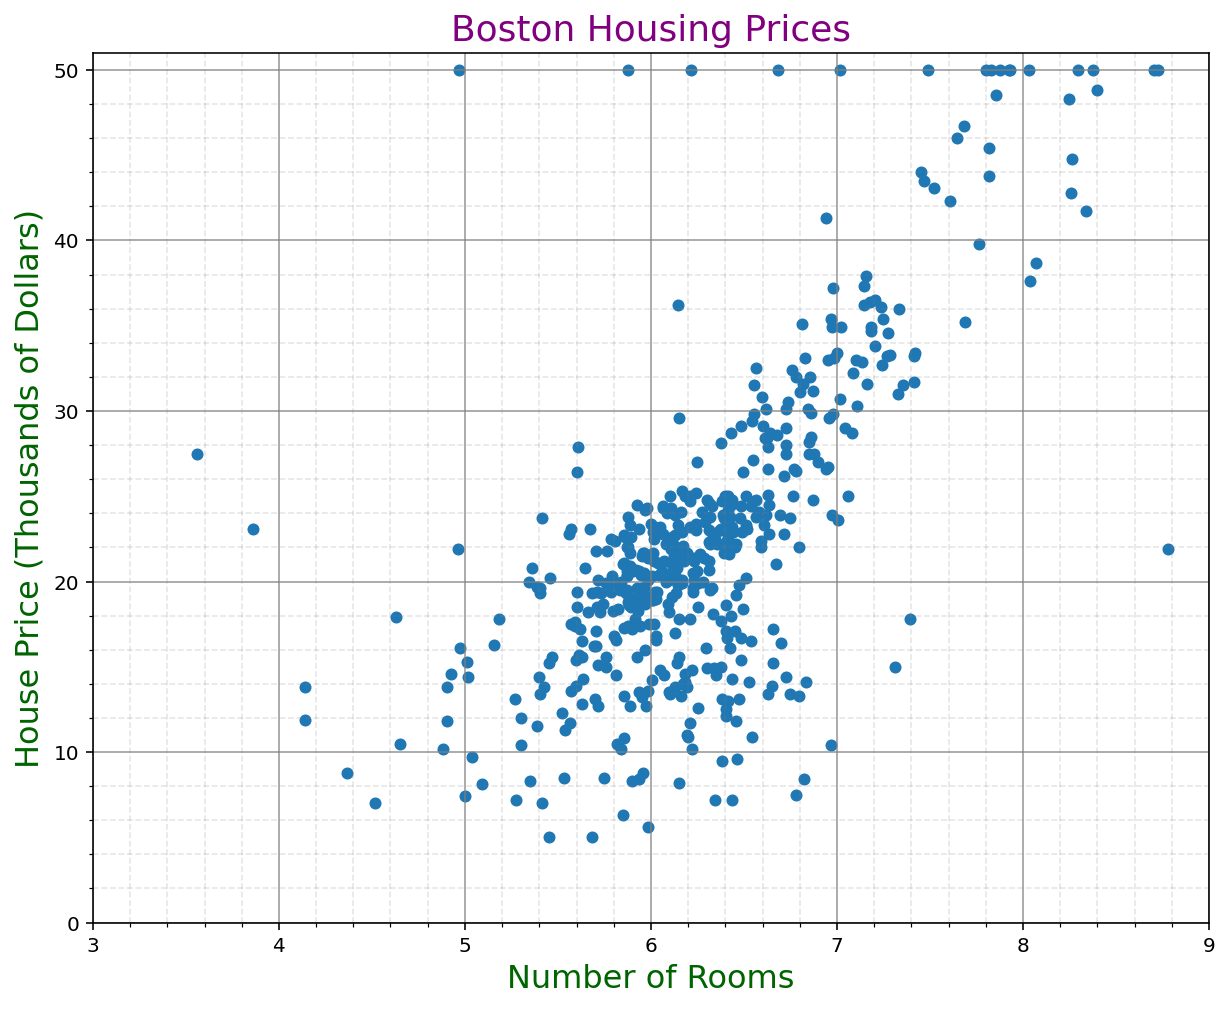

In [167]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(3, 9)
ax.set_ylim(0, 51)
ax.scatter(x=xBHP, y=yBHP,s=25)
ax.set_xlabel('Number of Rooms',fontsize=16,color='darkgreen')
ax.set_ylabel('House Price (Thousands of Dollars)',fontsize=16,color='darkgreen')
ax.set_title('Boston Housing Prices',fontsize=18,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

/tmp/ipykernel_54/576367120.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
/tmp/ipykernel_54/576367120.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)


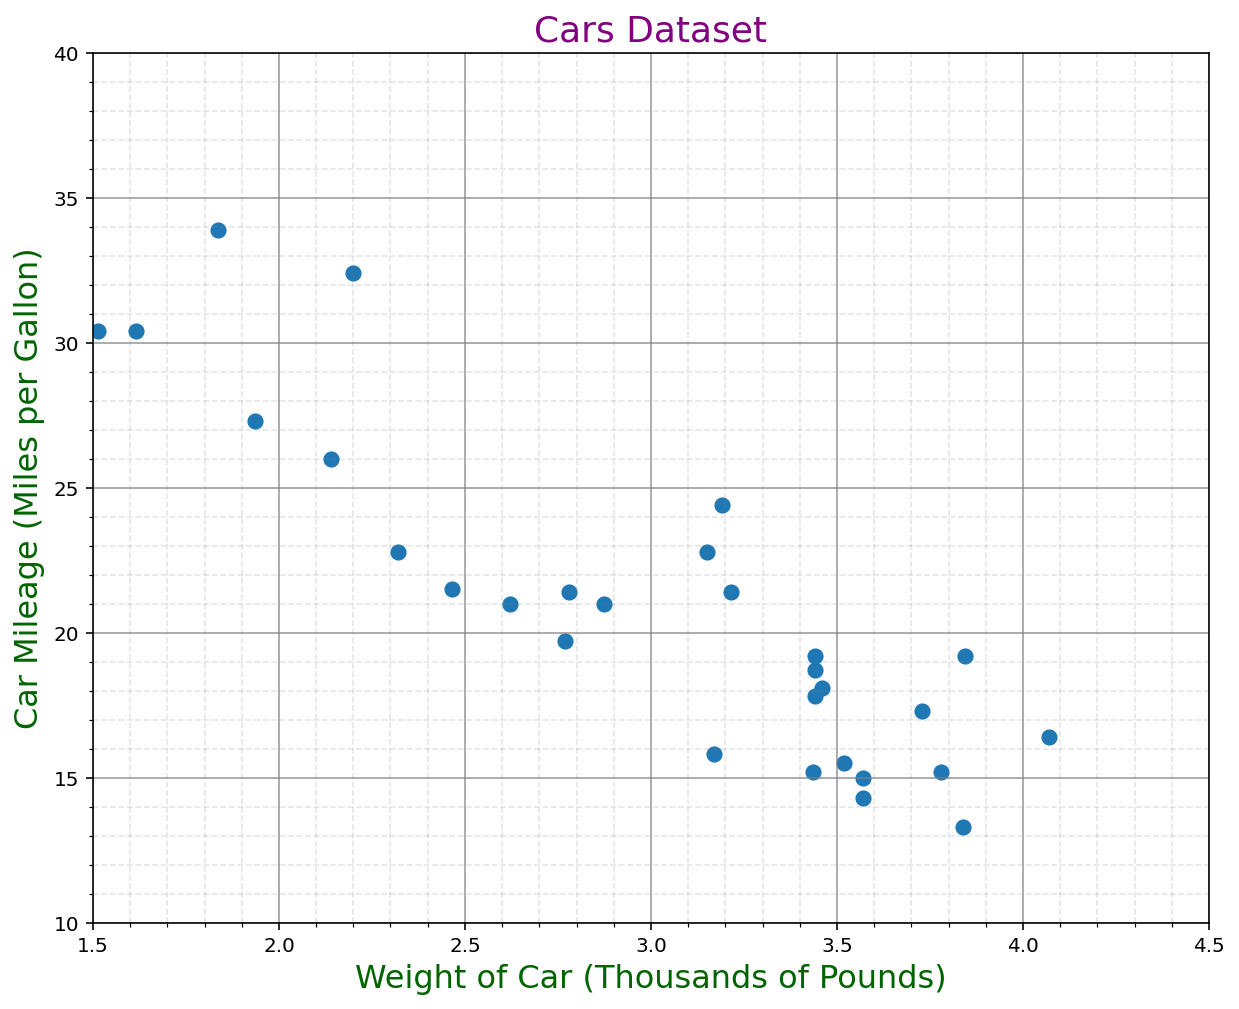

In [168]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(1.5, 4.5)
ax.set_ylim(10, 40)
ax.scatter(x=xcars, y=ycars,s=50)
ax.set_xlabel('Weight of Car (Thousands of Pounds)',fontsize=16,color='darkgreen')
ax.set_ylabel('Car Mileage (Miles per Gallon)',fontsize=16,color='darkgreen')
ax.set_title('Cars Dataset',fontsize=18,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

## Modelling

First we will use both methods to model the mtcars dataset.

In [169]:
from sklearn.metrics import mean_absolute_error

In [170]:
#from sklearn.model_selection import train_test_split as tts
#xtrain, xtest, ytrain, ytest = tts(xcars.values.reshape(-1,1), ycars, test_size = .25, random_state = 2)
model.fit(xcars, ycars)
ypred = model.predict(xcars)
matrix = np.column_stack([xcars, ypred])
ordered = matrix[np.argsort(matrix[:,0])]

/tmp/ipykernel_54/2911482533.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xcars, ycars)


/tmp/ipykernel_54/2670665263.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
/tmp/ipykernel_54/2670665263.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)


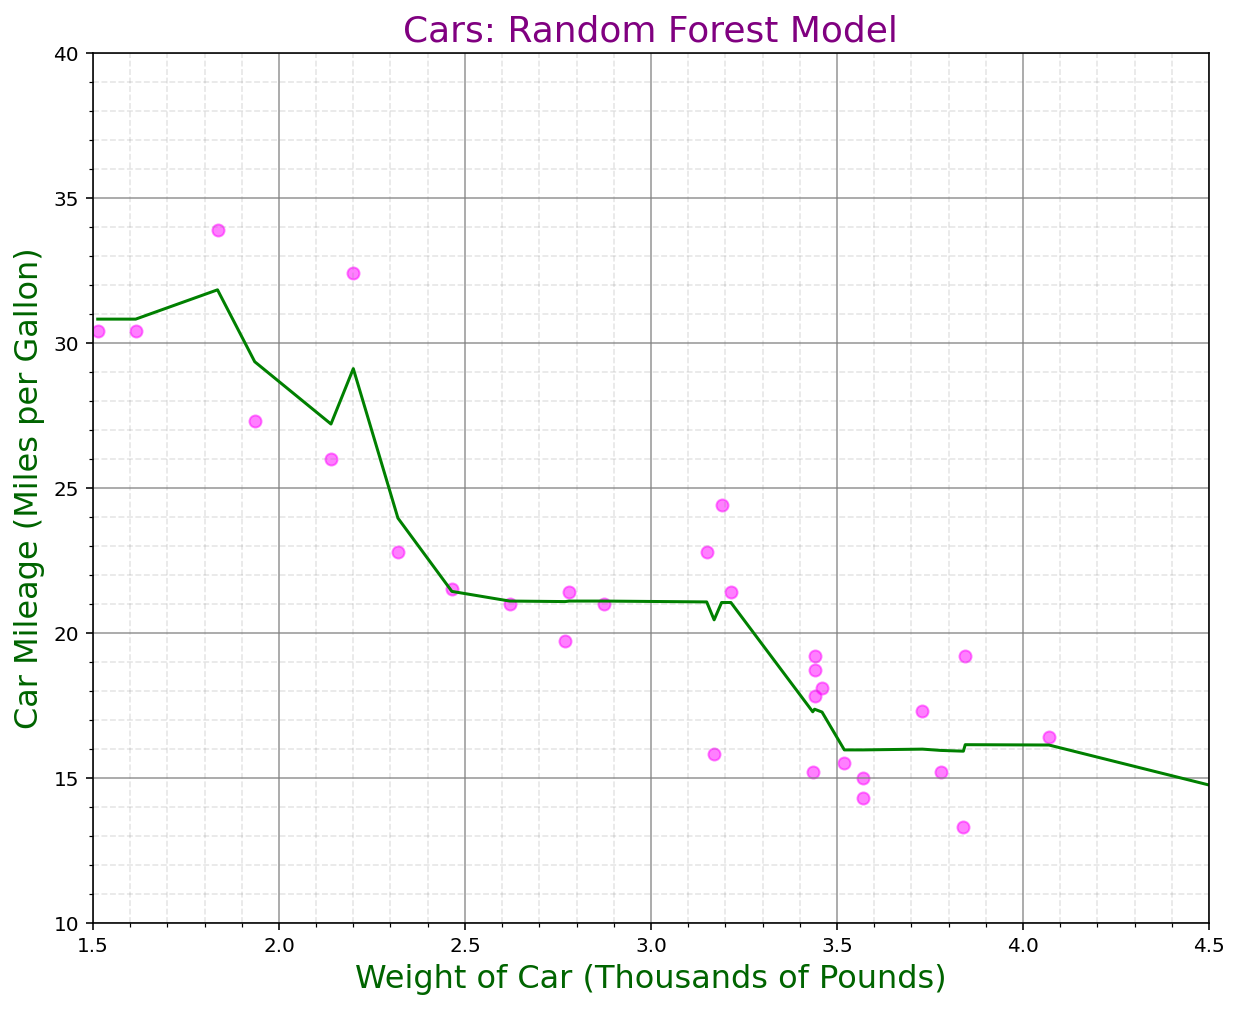

In [172]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(1.5, 4.5)
ax.set_ylim(10, 40)
plt.scatter(xcars.values, ycars, color = 'fuchsia', alpha = .5)
plt.plot(ordered[:,0], ordered[:,1], color = 'green')
ax.set_xlabel('Weight of Car (Thousands of Pounds)',fontsize=16,color='darkgreen')
ax.set_ylabel('Car Mileage (Miles per Gallon)',fontsize=16,color='darkgreen')
ax.set_title('Cars: Random Forest Model',fontsize=18,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

In [173]:
mean_absolute_error(ycars, ypred)

1.4268786704045229

In [174]:
model.fit(xBHP, yBHP)
ypred = model.predict(xBHP)
matrix = np.column_stack([xBHP, ypred])
ordered = matrix[np.argsort(matrix[:,0])]

/tmp/ipykernel_54/51222942.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xBHP, yBHP)


/tmp/ipykernel_54/422298204.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
/tmp/ipykernel_54/422298204.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)


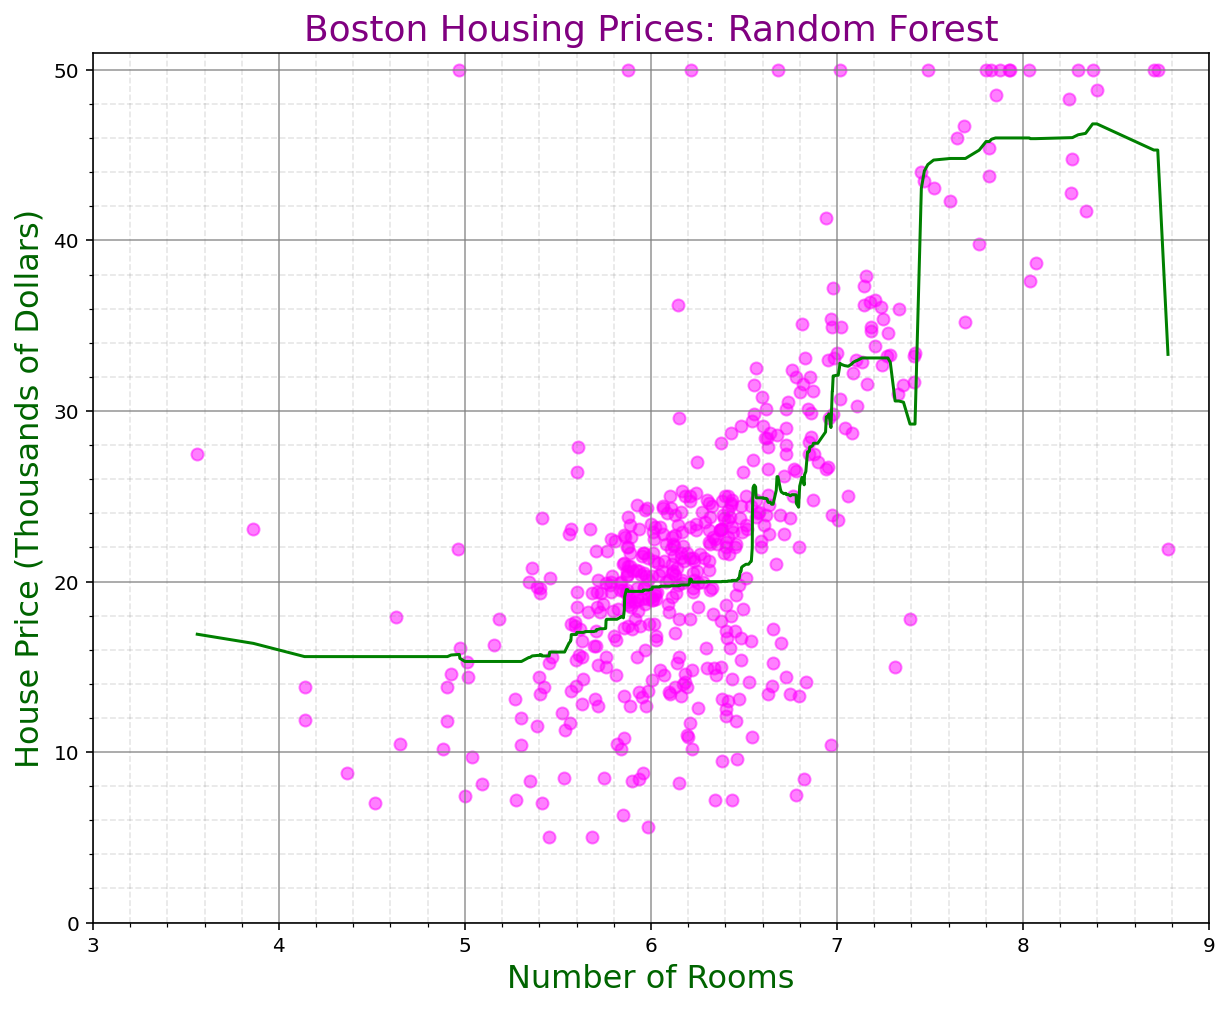

In [176]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(3, 9)
ax.set_ylim(0, 51)
plt.scatter(xBHP.values, yBHP, color = 'fuchsia', alpha = .5)
plt.plot(ordered[:,0], ordered[:,1], color = 'green')
ax.set_xlabel('Number of Rooms',fontsize=16,color='darkgreen')
ax.set_ylabel('House Price (Thousands of Dollars)',fontsize=16,color='darkgreen')
ax.set_title('Boston Housing Prices: Random Forest',fontsize=18,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

In [177]:
mean_absolute_error(yBHP, ypred)

3.908523425747278

## Lowess_kern

In [199]:
kern = tricubic

def tricubic(x):
    if len(x.shape) == 1:
        x = x.reshape(-1,1)
    d = np.sqrt(np.sum(x**2, axis = 1))
    return np.where(d>1,0,70/81*(1-d**3)**3)

def lowess_kern(x, y, kern, tau):

    # tau is called bandwidth K((x-x[i])/(2*tau))

    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the kernel function by using only the train data    
    w = np.array([kern((x - x[i])/(2*tau)) for i in range(n)])     
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        theta, res, rnk, s = np.linalg.lstsq(A, b)
        yest[i] = theta[0] + theta[1] * x[i] 

    return yest

In [200]:
dat = np.concatenate([xcars,ycars], axis=1)

# this is sorting the rows based on the first column
dat = dat[np.argsort(dat[:, 0])]

dat_test = np.concatenate([xcars,ycars], axis=1)
dat_test = dat_test[np.argsort(dat_test[:, 0])]

In [201]:
Yhat_lowess = lowess_kern(dat[:,0],dat[:,1],tricubic,0.6)

/tmp/ipykernel_54/552813275.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta, res, rnk, s = np.linalg.lstsq(A, b)


In [202]:
datl = np.concatenate([dat[:,0].reshape(-1,1),Yhat_lowess.reshape(-1,1)], axis=1)

In [203]:
from scipy.interpolate import interp1d

f = interp1d(datl[:,0], datl[:,1],fill_value='extrapolate')

yhat = f(dat_test[:,0])

/tmp/ipykernel_54/3364717128.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
/tmp/ipykernel_54/3364717128.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)


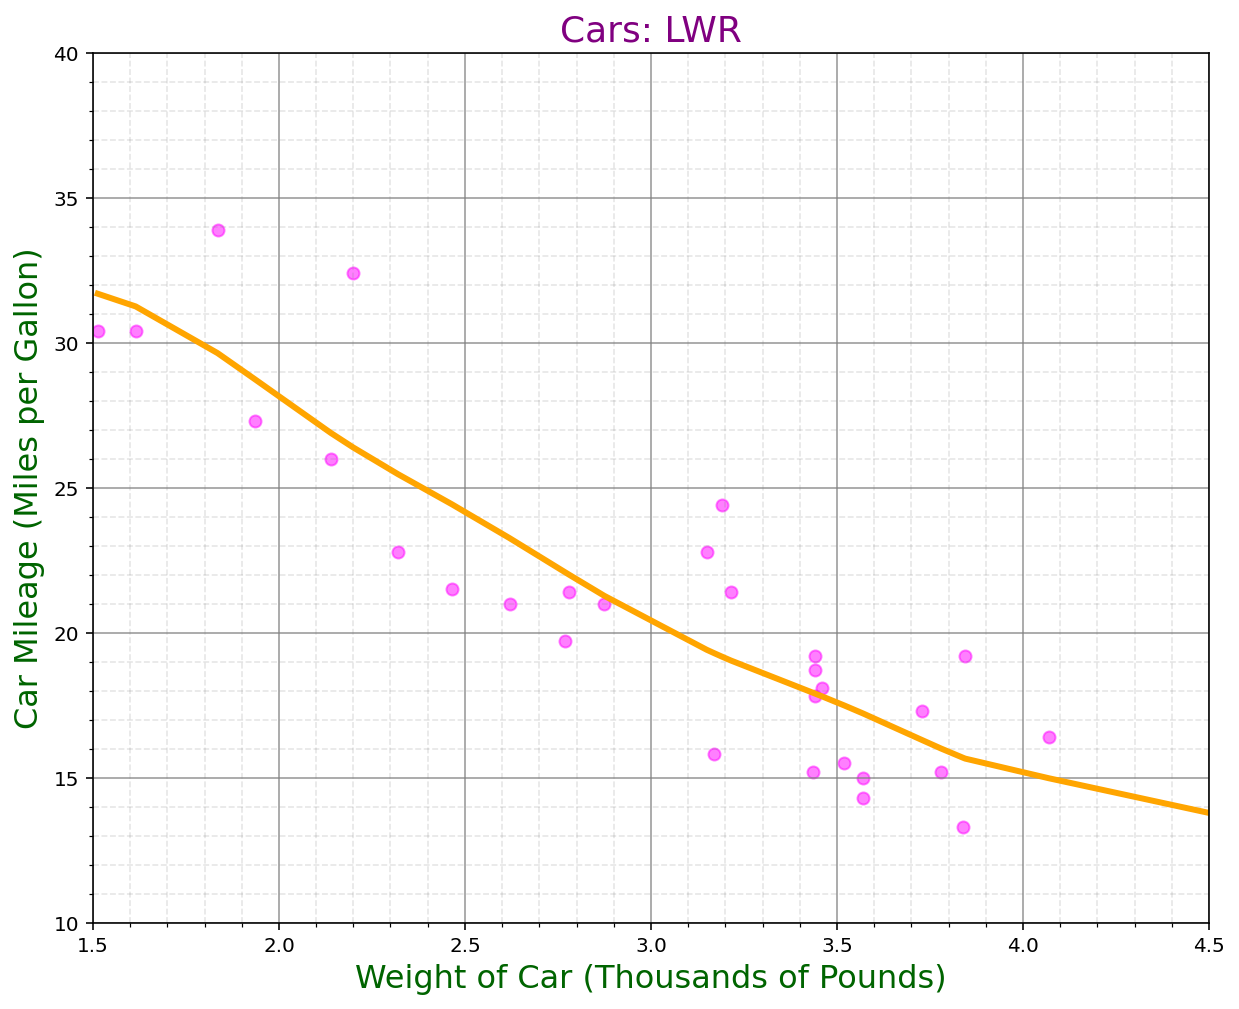

In [204]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(1.5, 4.5)
ax.set_ylim(10, 40)
plt.scatter(xcars.values, ycars, color = 'fuchsia', alpha = .5)
ax.plot(dat_test[:,0], yhat, color='orange',lw=3)
#plt.plot(ordered[:,0], ordered[:,1], color = 'green')
ax.set_xlabel('Weight of Car (Thousands of Pounds)',fontsize=16,color='darkgreen')
ax.set_ylabel('Car Mileage (Miles per Gallon)',fontsize=16,color='darkgreen')
ax.set_title('Cars: LWR',fontsize=18,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

In [205]:
mean_absolute_error(dat_test[:, 1], yhat)

2.1104911808531237

In [206]:
dat = np.concatenate([xBHP,yBHP], axis=1)

# this is sorting the rows based on the first column
dat = dat[np.argsort(dat[:, 0])]

dat_test = np.concatenate([xBHP,yBHP], axis=1)
dat_test = dat_test[np.argsort(dat_test[:, 0])]

In [207]:
Yhat_lowess = lowess_kern(dat[:,0],dat[:,1],tricubic,0.6)

/tmp/ipykernel_54/552813275.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta, res, rnk, s = np.linalg.lstsq(A, b)


In [208]:
datl = np.concatenate([dat[:,0].reshape(-1,1),Yhat_lowess.reshape(-1,1)], axis=1)

In [209]:
f = interp1d(datl[:,0], datl[:,1],fill_value='extrapolate')

yhat = f(dat_test[:,0])

/tmp/ipykernel_54/4129625401.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
/tmp/ipykernel_54/4129625401.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)


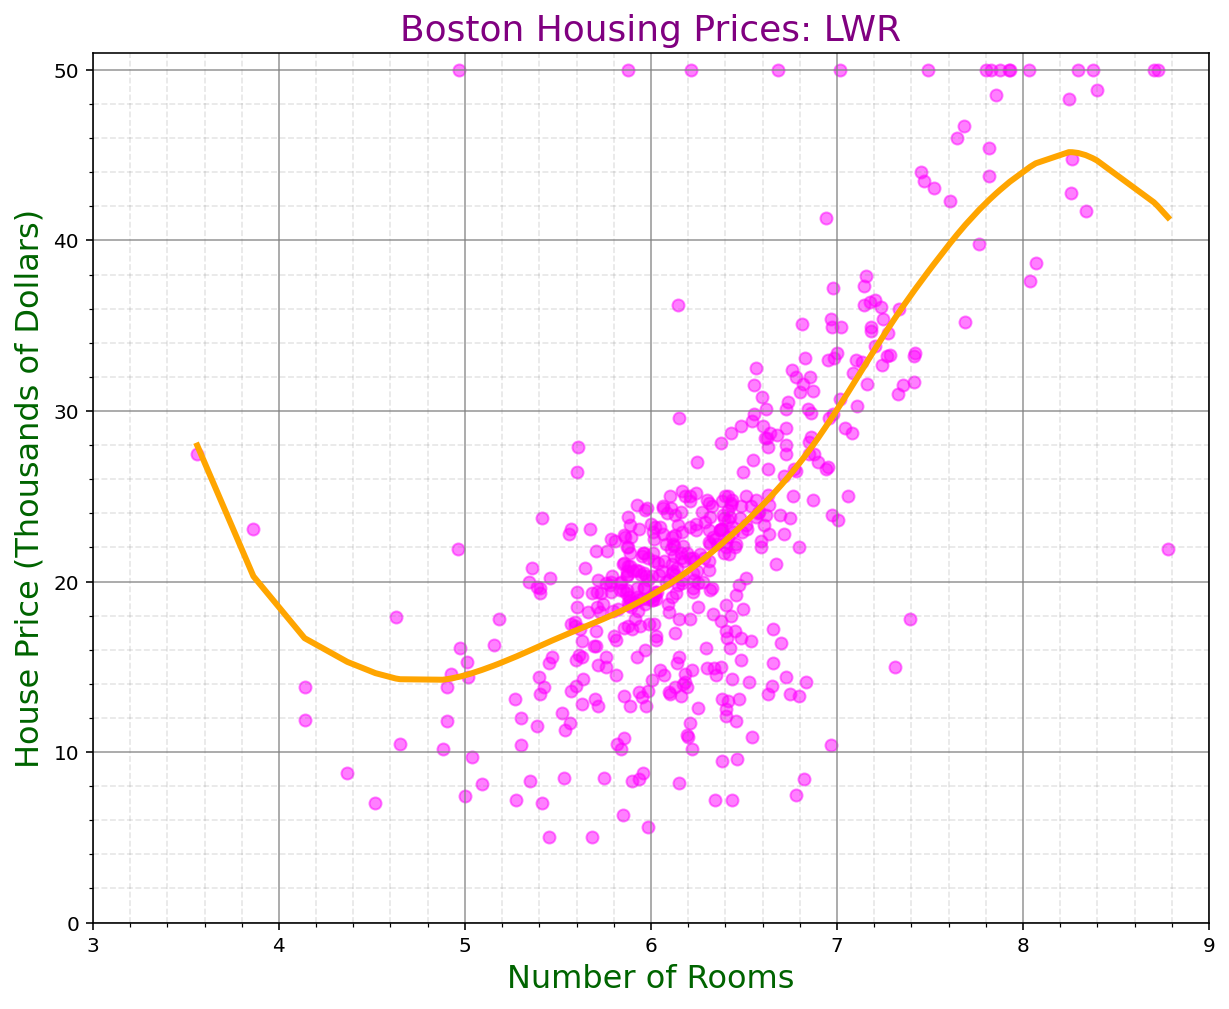

In [210]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(3, 9)
ax.set_ylim(0, 51)
plt.scatter(xBHP.values, yBHP, color = 'fuchsia', alpha = .5)
ax.plot(dat_test[:,0], yhat, color='orange',lw=3)
ax.set_xlabel('Number of Rooms',fontsize=16,color='darkgreen')
ax.set_ylabel('House Price (Thousands of Dollars)',fontsize=16,color='darkgreen')
ax.set_title('Boston Housing Prices: LWR',fontsize=18,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

In [211]:
mean_absolute_error(dat_test[:,1], yhat)

4.040651916485079

## Final Results

- For the cars dataset, the MAE for the random forest model was 1.427, and for the LWR model was 2.110.

- For the Boston Housing Prices Dataset, the MAE for the random forest model was 3.909, and for the LWR model was 4.041.

Thus, while slight, we can claim that for both of our test cases, the **random forest model** performed better.